In [36]:
import pyspark.sql.functions as f
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')


import re
import string
from collections import Counter
from nltk import word_tokenize
from pyspark.sql import SparkSession
from sklearn.feature_extraction.text import CountVectorizer
from pyspark.sql.types import StructType,StructField, StringType,IntegerType,BooleanType,DoubleType
from pyspark.sql.functions import sum, col, desc, udf, concat, lower


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
spark = SparkSession.builder\
        .master('local[*]')\
        .appName("\Yelp_regional_analysis")\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/19 01:43:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

## **Data Preprocessing**

In [4]:
df_yelp_review = spark.read.json("shared/student-data/yelp/yelp_academic_dataset_review.json")

In [5]:
#Load review data and cut out unused info
cols_to_drop = ['date','review_id','user_id']
df_yelp_review = df_yelp_review.drop(*cols_to_drop)\
                .withColumnRenamed('stars','reviewer_rating')\
                .withColumnRenamed('text','review')
df_yelp_review.show(n = 5)

+--------------------+----+-----+---------------+--------------------+------+
|         business_id|cool|funny|reviewer_rating|              review|useful|
+--------------------+----+-----+---------------+--------------------+------+
|buF9druCkbuXLX526...|   1|    1|            4.0|Apparently Prides...|     3|
|RA4V8pr014UyUbDvI...|   0|    0|            4.0|This store is pre...|     1|
|_sS2LBIGNT5NQb6PD...|   0|    0|            5.0|I called WVM on t...|     0|
|0AzLzHfOJgL7ROwhd...|   1|    1|            2.0|I've stayed at ma...|     1|
|8zehGz9jnxPqXtOc7...|   0|    0|            4.0|The food is alway...|     0|
+--------------------+----+-----+---------------+--------------------+------+
only showing top 5 rows



In [6]:
#Load business data and cut out unused info
df_yelp_business = spark.read.json("shared/student-data/yelp/yelp_academic_dataset_business.json")
cols_to_drop = ['address','hours','is_open','latitude','longitude','postal_code','attributes']
df_yelp_business = df_yelp_business.drop(*cols_to_drop)
df_yelp_business.show(n=5)
print("Total number of business ratings: ", df_yelp_business.count())

21/12/19 01:45:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+-----------+--------------------+------------+-----+-----+
|         business_id|          categories|       city|                name|review_count|stars|state|
+--------------------+--------------------+-----------+--------------------+------------+-----+-----+
|6iYb2HFDywm3zjuRg...|Gastropubs, Food,...|    Boulder| Oskar Blues Taproom|          86|  4.0|   CO|
|tCbdrRPZA0oiIYSmH...|Salad, Soup, Sand...|   Portland|Flying Elephants ...|         126|  4.0|   OR|
|bvN78flM8NLprQ1a1...|Antiques, Fashion...|   Portland|      The Reclaimory|          13|  4.5|   OR|
|oaepsyvc0J17qwi8c...|Beauty & Spas, Ha...|Orange City|         Great Clips|           8|  3.0|   FL|
|PE9uqAjdw0E4-8mjG...|Gyms, Active Life...|    Atlanta|   Crossfit Terminus|          14|  4.0|   GA|
+--------------------+--------------------+-----------+--------------------+------------+-----+-----+
only showing top 5 rows



Total number of business ratings:  160585


In [7]:
#Filter information, so only resturuants info are showing
df_yelp_business = df_yelp_business.filter(df_yelp_business.categories.contains('Restaurant'))
df_yelp_business.show(n=5)
print("Total number of restaurants ratings: ", df_yelp_business.count())

+--------------------+--------------------+---------+--------------------+------------+-----+-----+
|         business_id|          categories|     city|                name|review_count|stars|state|
+--------------------+--------------------+---------+--------------------+------------+-----+-----+
|6iYb2HFDywm3zjuRg...|Gastropubs, Food,...|  Boulder| Oskar Blues Taproom|          86|  4.0|   CO|
|tCbdrRPZA0oiIYSmH...|Salad, Soup, Sand...| Portland|Flying Elephants ...|         126|  4.0|   OR|
|D4JtQNTI4X3Kcbzac...|   Restaurants, Thai|Vancouver| Bob Likes Thai Food|         169|  3.5|   BC|
|jFYIsSb7r1QeESVUn...|Breakfast & Brunc...| Columbus|     Boxwood Biscuit|          11|  4.5|   OH|
|HPA_qyMEddpAEtFof...|Food, Pizza, Rest...|  Peabody| Mr G's Pizza & Subs|          39|  4.0|   MA|
+--------------------+--------------------+---------+--------------------+------------+-----+-----+
only showing top 5 rows



Total number of restaurants ratings:  50793


In [10]:
#Find the most common locations of the Restaurant rating given in the dataset
#This step helps us to determine which city to pick for the regional analysis
df_yelp_business.groupBy('city').count().sort(desc('count')).show(n = 10)

+---------+-----+
|     city|count|
+---------+-----+
| Portland| 5737|
|Vancouver| 5029|
|   Austin| 4965|
|  Atlanta| 4180|
|  Orlando| 3749|
|   Boston| 2846|
| Columbus| 2634|
| Richmond|  901|
|Cambridge|  775|
|Kissimmee|  700|
+---------+-----+
only showing top 10 rows



### **Atlanta analysis**

Atlanta businesses type


<AxesSubplot:xlabel='Businesses type', ylabel='number'>

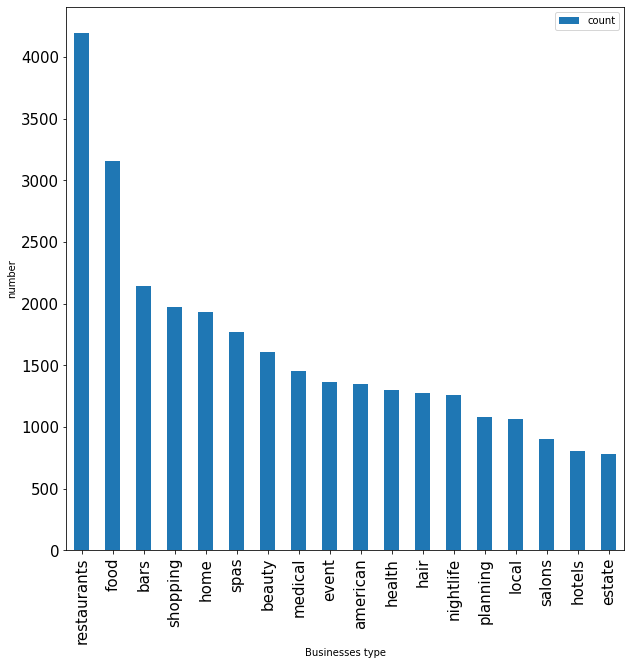

In [55]:
atl_bus = df_yelp_business.filter(df_yelp_business.city.contains('Atlanta'))\
                        .orderBy('review_count',ascending = False)

atl_bus = atl_bus.withColumn('categ',f.translate(f.col('categories'),"[,&()],",""))
atl_bus = atl_bus.withColumn('new categ',f.lower('categ'))
atl_bus = atl_bus.drop('categories')
atl_bus = atl_bus.drop('categ')

pd_atl_bus = atl_bus.withColumn('category count',f.explode(f.split('new categ'," ")))\
            .groupBy('category count')\
            .count()\
            .sort(desc('count'))\
            .toPandas()

#To get rid of space and 'service'
pd_atl_bus = pd_atl_bus[2:20]
print('Atlanta businesses type')
pd_atl_bus.plot(x= "category count",y = "count",
              figsize =[10,10],kind ='bar',
             fontsize = 15, xlabel = 'Businesses type',
                ylabel = 'number')

###### The bar chart above shows all of the business types in Atlanta given in the dataset.
###### There could be overlap of the bars due to synonyms in categories, such as 'restaruants' and 'food'.
######  But this is a general distribution of different businesses in the city.
######  We will analyze more data in the restaurant category.

In [15]:
#Filter "city" so we obtain the restaurant ratings in Atlanta 
#Then filter the star rating with number of review count to find highly rated popular resturuants

atl_restr_data = df_yelp_business.filter(df_yelp_business.city.contains('Atlanta'))\
                .filter(df_yelp_business.stars > 3.9)\
                .orderBy('review_count',ascending=False)
col_sel = ['name','review_count','stars','categories']
atl_restr_data_table = atl_restr_data.select(*col_sel)

#Top 10 highly rated popular restr in Atlanta is showing below
pd_atl_restr_data_table = atl_restr_data_table.toPandas()
pd.set_option("display.max_colwidth",-1)
pd_atl_restr_data_table.head(10)

/opt/conda/envs/bigdata/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


,name,review_count,stars,categories
0,Mary Mac's Tea Room,3861,4.0,"Venues & Event Spaces, Event Planning & Services, Comfort Food, Southern, Restaurants, Nightlife, Tea Rooms, Food, Bars"
1,Fox Bros. Bar-B-Q,3825,4.5,"Southern, Restaurants, Barbeque, American (Traditional)"
2,Atlanta Breakfast Club,3761,4.5,"Restaurants, Breakfast & Brunch, American (Traditional), Southern, Coffee & Tea, American (New), Food"
3,Poor Calvin's,3379,4.5,"Southern, Nightlife, Thai, Food, American (New), Ethnic Food, Restaurants, Beer, Wine & Spirits, Asian Fusion, Bars, Comfort Food, Specialty Food, Seafood"
4,Antico Pizza,3135,4.0,"Italian, Pizza, Restaurants"
5,Two Urban Licks,2730,4.0,"Bars, American (New), Nightlife, Southern, Restaurants"
6,South City Kitchen Midtown,2618,4.5,"Restaurants, American (New), Southern, Breakfast & Brunch, Gluten-Free"
7,Fat Matt's Rib Shack,2165,4.0,"Restaurants, Barbeque, Fast Food, Nightlife, Southern, Beer Bar, Bars, American (Traditional)"
8,FLIP burger boutique,1909,4.0,"Burgers, Specialty Food, Restaurants, Barbeque, Food, Nightlife, Bars, American (New)"
9,Canoe,1844,4.5,"Seafood, Restaurants, Breakfast & Brunch, American (New)"


##### Above is a table of the most popular highly rated (> 4.0 stars) restaurants in Atlanta

In [16]:
#Clean column "categories"

atl_restr_data = atl_restr_data.withColumn('new_categories',f.regexp_replace(f.col('categories'),"[,&()]",""))
atl_restr_data = atl_restr_data.withColumn('new_categories1',f.lower(f.col('new_categories')))
atl_restr_data = atl_restr_data.withColumn('new_categories2',f.regexp_replace(f.col('new_categories1'),"restaurants",""))
atl_restr_data = atl_restr_data.withColumn('new_categories3',f.regexp_replace(f.col('new_categories2'),"food",""))
atl_restr_data = atl_restr_data.withColumn('new_categories4',f.regexp_replace(f.col('new_categories3'),"nightlife",""))
atl_restr_data = atl_restr_data.withColumn('new categories',f.regexp_replace(f.col('new_categories4'),"new",""))

col_to_drop = ['categories','new_categories',
               'new_categories1','new_categories2',
               'new_categories3','new_categories4']
atl_restr_data = atl_restr_data.drop(*col_to_drop)

#pd_atl_restr_data = atl_restr_data.toPandas()
#pd_atl_restr_data.head(3)

In [17]:
#word count to find the most popular type of food in Atlanta
pd_temp_atl = atl_restr_data.withColumn('word',f.explode(f.split('new categories',' ')))\
                            .groupBy('word')\
                            .count()\
                            .sort(desc('count'))\
                            .toPandas()
#Top 20 food categories in Atlanta
pd_temp_atl[1:30]

,word,count
1,bars,670
2,american,478
3,sandwiches,227
4,brunch,192
5,breakfast,192
6,traditional,184
7,tea,164
8,coffee,162
9,services,153
10,event,150


<AxesSubplot:xlabel='Type of food', ylabel='count'>

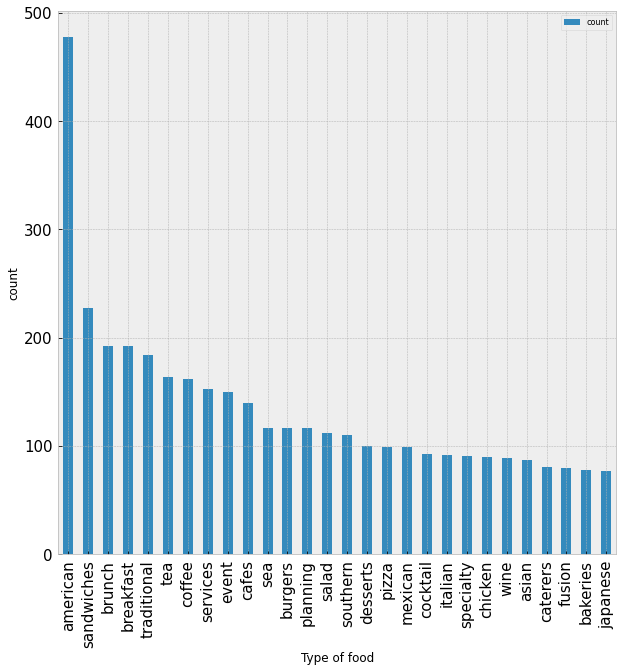

In [19]:
#Visualization of popular food category in Atlanta
pd_temp_atl = pd_temp_atl.iloc[1:30]                 #Get rid of space
pd_temp_atl.plot(x ='word',y='count',
                 xlabel = 'Type of food',ylabel ='count',
                 fontsize = 15, figsize = (10,10),
                 kind ='bar')

##### The bar chart above shows the most popular food type among the highly rated restaurants.

In [8]:
#Join review and atl_restr_data to find Atlanta resturuant review
atl_restr = df_yelp_business.filter(df_yelp_business.city.contains('Atlanta'))\
                .orderBy('review_count',ascending=False)
atl_restr_review = atl_restr\
                        .join(df_yelp_review, atl_restr.business_id == df_yelp_review.business_id,"inner")\
                        .drop("business_id")
pd_atl_restr_review = atl_restr_review.toPandas()

#Reorder the columns
atl_restr_review = atl_restr_review.select('city','state','name','stars','review_count',
                                                   'categories','reviewer_rating','review',
                                                   'useful','cool','funny')
pd_atl_restr_review = pd_atl_restr_review[['city','state','name','stars','review_count',
                                                   'categories','reviewer_rating','review',
                                                   'useful','cool','funny']]

In [9]:
#Filter out low rating reviews (1 star)
pd_atl_restr_review_low = pd_atl_restr_review.loc[pd_atl_restr_review['reviewer_rating'] < 1.1]\
                                                .filter(['review'])
pd_atl_restr_review_low.head(3)


,review
4,"Service poor , music loud . Not the place it u..."
62,This is more of a customer service review.. I ...
73,I had never had Greek before and I was really ...


In [10]:
#Clean string
user_defined_stopwords = ['us',
                          'one',
                          'back',
                          'get',
                          'like',
                          'would',
                          'go',
                          'said',
                          'could',
                          'im',
                          'dont',
                          'didnt',
                          'went',
                          'really',
                          'also',
                          'ive',
                          'even']
stopwords = nltk.corpus.stopwords.words('english') + list(string.punctuation)+ user_defined_stopwords
def preprocess(x):
    x = re.sub('[^a-z\s]','',x.lower())
    x = [w for w in x.split() if w not in set(stopwords)]
    return ' '.join(x)


In [11]:
#Clean the string in 1 star rating review
pd_atl_restr_review_low['new_review'] = pd_atl_restr_review_low['review'].apply(preprocess)
pd_atl_restr_review_low.head(3)

,review,new_review
4,"Service poor , music loud . Not the place it u...",service poor music loud place use sitting bar ...
62,This is more of a customer service review.. I ...,customer service review walked sat bar pm plac...
73,I had never had Greek before and I was really ...,never greek excited kyma made reservation wish...


In [17]:
#Bigram of low rating reviews
bigram_freq = lambda s:list(nltk.FreqDist(nltk.bigrams(s.split(" "))).items())

out = pd_atl_restr_review_low['new_review'].apply(bigram_freq).explode()
out = pd.DataFrame(out.to_list(),index = out.index,columns = ["review words","bigrams"])
out

,review words,bigrams
4,"(service, poor)",1.0
4,"(poor, music)",1.0
4,"(music, loud)",1.0
4,"(loud, place)",1.0
4,"(place, use)",1.0
...,...,...
600531,"(attitudes, reason)",1.0
600531,"(reason, food)",1.0
600531,"(food, good)",1.0
600531,"(good, shouldnt)",1.0


In [14]:
#Plot of word frequencies in low rating reviews
unigram_count = pd_atl_restr_review_low.new_review.str.split(expand = True).stack().value_counts().reset_index()
unigram_count.columns = ['word','frequency']
unigram_count = unigram_count[0:9]

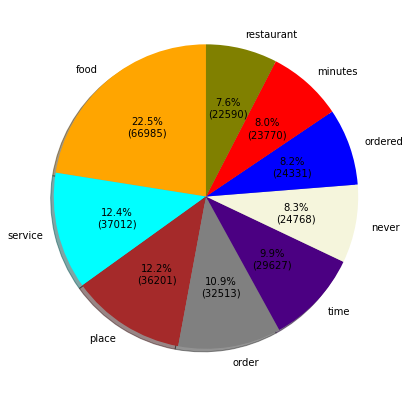

In [15]:
#Most common words used in 1 star review
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
colors = ( "orange", "cyan", "brown",
          "grey", "indigo", "beige",
          "blue","red","olive","bisque")
fig, ax = plt.subplots(figsize =(10, 7))
autotexts = ax.pie(unigram_count['frequency'],
                autopct = lambda pct: func(pct, unigram_count['frequency']),                                  
                labels = unigram_count['word'],
                shadow = True,
                colors = colors,
                startangle = 90,
                textprops = dict(color ="black"))
 
plt.show()

In [19]:
#Filter out high rating reviews(5 stars)
pd_atl_restr_review_high = pd_atl_restr_review.loc[pd_atl_restr_review['reviewer_rating'] > 4.9]\
                                                .filter(['review'])
pd_atl_restr_review_high['new_review'] = pd_atl_restr_review_high['review'].apply(preprocess)

In [34]:
pd_atl_restr_review_high['new_review'] = pd_atl_restr_review_high['new_review'].astype('str')

In [35]:
pd_atl_restr_review_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229809 entries, 0 to 600527
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   review      229809 non-null  object
 1   new_review  229809 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


In [ ]:
#Bigram of high rating reviews
#bigram_freq = lambda s:list(nltk.FreqDist(nltk.bigrams(s.split(" "))).items())

#out = pd_atl_restr_review_high['new_review'].apply(bigram_freq).explode()
#out = pd.DataFrame(out.to_list(),index = out.index,columns = ["review words","bigrams"])
#out
txt = pd_atl_restr_review_high.new_review
words = nltk.tokenize.word_tokenize(txt)
bigrm = list(nltk.bigrams(words))
word_dist = nltk.FreqDist([' '.join(x)for x in bigram])
rslt = pd.DataFrame(word_dist.most_common(10),
                   columns=['Bigram','Frequency'])

In [17]:
#Word count in high rating reviews
unigram_count = pd_atl_restr_review_high.new_review.str.split(expand = True).stack().value_counts().reset_index()
unigram_count.columns = ['word','frequency']

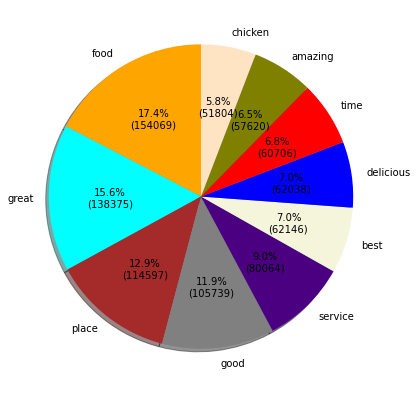

In [20]:
#Most common words used in 5 star review
unigram_count = unigram_count[0:10]

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)
 
colors = ( "orange", "cyan", "brown",
          "grey", "indigo", "beige",
          "blue","red","olive","bisque")
fig, ax = plt.subplots(figsize =(10, 7))
autotexts = ax.pie(unigram_count['frequency'],
                autopct = lambda pct: func(pct, unigram_count['frequency']),                                  
                labels = unigram_count['word'],
                shadow = True,
                colors = colors,
                startangle = 90,
                textprops = dict(color ="black"))
 
plt.show()

## Jinya Ramen bar

Anything below this line are not included in the final report, as this is my personal discovery. 
Jinya Ramen bar is a chain restaurants aross North America. The shop located in Atlanta has the highest average rating overall. About 870 people rated 4.5 stars and more than 88% of the reviewers rated 4 stars and above. I tried this ramen bar personally a few years ago, and it was the best ramen bar I have ever tried. Better than any famous ramen shop I tried in NYC (Ippudo, Ichiran, Tamashi, etc.). If you have a change to visit Atlanta, I highly recommand you to try it out!

For anyone who notice this message.
Mary Nie

In [56]:
#Reload the yelp business dataset so we have the full information
df_yelp_business = spark.read.json("shared/student-data/yelp/yelp_academic_dataset_business.json")
cols_to_drop = ['is_open','latitude','longitude','attributes']
df_yelp_business = df_yelp_business.drop(*cols_to_drop)

#Find JINYA ramen bar business id
Jinya_atl = df_yelp_business.filter(df_yelp_business.city.contains('Atlanta'))\
                            .filter(df_yelp_business.name.contains("JINYA"))\
                            .orderBy('review_count',ascending=False)
Jinya_atl.select('business_id').show(truncate = 0)

+----------------------+
|business_id           |
+----------------------+
|57d0Gmx4JKuKQWyJYu0yfg|
+----------------------+



In [47]:
#Find all JINYA shop in the dataset
Jinya = df_yelp_business.filter(df_yelp_business.name.contains("JINYA"))
Jinya.select('city','state','name','review_count','stars').show()

+-------------+-----+--------------------+------------+-----+
|         city|state|                name|review_count|stars|
+-------------+-----+--------------------+------------+-----+
|       Austin|   TX|JINYA Ramen Bar -...|         779|  3.5|
|      Orlando|   FL|JINYA Ramen Bar -...|         515|  4.0|
|    Vancouver|   BC|     JINYA Ramen Bar|         340|  3.5|
|    Vancouver|   BC| JINYA Ramen Express|          12|  3.0|
|Sandy Springs|   GA|     JINYA Ramen Bar|        1246|  4.5|
|      Atlanta|   GA|JINYA Ramen Bar -...|         870|  4.5|
|    Vancouver|   BC|     JINYA Ramen Bar|         196|  3.5|
|    Vancouver|   BC|     JINYA Ramen Bar|         307|  3.5|
|      Burnaby|   BC|     JINYA Ramen Bar|         222|  3.0|
+-------------+-----+--------------------+------------+-----+



##### **JINYA ramen bar is a chain ramen bar with various locations across North America**

In [51]:
#Find JINYA Atalanta information

Jinya_atl.select('name','address','city','state','postal_code').show(truncate =0)

+--------------------------+------------------------+-------+-----+-----------+
|name                      |address                 |city   |state|postal_code|
+--------------------------+------------------------+-------+-----+-----------+
|JINYA Ramen Bar - Buckhead|3714 Roswell Rd, Unit 35|Atlanta|GA   |30342      |
+--------------------------+------------------------+-------+-----+-----------+



In [52]:
#Find open hours of the address above
Jinya_atl.select('hours').show(truncate =0)

+-----------------------------------------------------------------------------+
|hours                                                                        |
+-----------------------------------------------------------------------------+
|{11:0-22:0, 11:0-21:0, 11:0-22:0, 11:0-21:0, 11:0-21:0, 11:0-21:0, 11:0-21:0}|
+-----------------------------------------------------------------------------+



In [23]:
#Find reviews of JINYA Atlanta
Jinya_rev = df_yelp_review.filter(df_yelp_review.business_id.contains("57d0Gmx4JKuKQWyJYu0yfg"))

In [12]:
#Convert to pandas for visialization
Jinya_rate = Jinya_rev.groupBy('reviewer_rating')\
                        .count()\
                        .toPandas()             

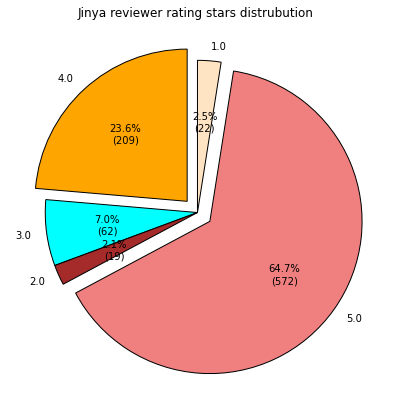

In [18]:
#Plot the rating distribution as a pie chart
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct,absolute)
 
colors = ( "orange", "cyan", "brown",
          "lightcoral", "bisque")
explode = (0.1, 0.0, 0.0, 0.1, 0.0)
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
fig, ax = plt.subplots(figsize =(10, 7))
autotexts = ax.pie(Jinya_rate['count'],
                autopct = lambda pct: func(pct, Jinya_rate['count']),                                  
                labels = Jinya_rate['reviewer_rating'],
                explode = explode,
                shadow = False,
                wedgeprops = wp,
                colors = colors,
                startangle = 90,
                textprops = dict(color ="black"))
 
ax.set_title("Jinya reviewer rating stars distrubution ")
plt.show()

In [59]:
#Find positive and most helpful reviews
Jinya_rev = Jinya_rev.orderBy(['reviewer_rating','useful'],ascending = False)
Jinya_rev.select('review').show(3,truncate = 0)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------